<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

<!-- TODO(b/319266067) remove temporary advert after a few weeks. -->
<div class="markdown-google-sans">
  <h2>Explore the Gemini API</h2>
  <p>The Gemini API gives you access to Gemini models created by Google DeepMind. Gemini models are built from the ground up to be multimodal, so you can reason seamlessly across text, images, code, and audio.
  </p>
  <strong>How to get started</strong>
    <ol>
      <li>Go to <a href="https://aistudio.google.com/">Google AI Studio</a> and log in with your Google account.</li>
      <li><a href="https://aistudio.google.com/app/apikey">Create an API key</a>.</li>
      <li>Use a quickstart for <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Prompting.ipynb">Python</a>, or call the REST API using <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb">curl</a>.</li>
      </ol>
  <strong>Explore use cases</strong>
    <ul>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Market_a_Jet_Backpack.ipynb">Create a marketing campaign</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Audio.ipynb">Analyze audio recordings</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/System_instructions.ipynb">Use System instructions in chat</a></li>
    </ul>
  <p>To learn more, check out the <a href="https://github.com/google-gemini/cookbook">Gemini cookbook</a> or visit the <a href="https://ai.google.dev/docs/">Gemini API documentation</a>.
  </p>
</div>


If you're already familiar with Colab, check out this video to learn about interactive tables, the executed code history view, and the command palette.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  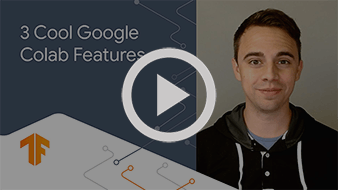
  </a>
</center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import string
import numpy as np
import json

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

import tensorflow as tf
tf.random.set_seed(2)
from numpy.random import seed
seed(1)


df1 = pd.read_csv('/content/drive/MyDrive/data mining/USvideos.csv')
df2 = pd.read_csv('/content/drive/MyDrive/data mining/CAvideos.csv')
df3 = pd.read_csv('/content/drive/MyDrive/data mining/GBvideos.csv')


data1 = json.load(open('/content/drive/MyDrive/data mining/US_category_id.json'))
data2 = json.load(open('/content/drive/MyDrive/data mining/CA_category_id.json'))
data3 = json.load(open('/content/drive/MyDrive/data mining/GB_category_id.json'))

joining frames and processing

In [ ]:
def category_extractor(data):
    i_d = [data['items'][i]['id'] for i in range(len(data['items']))]
    title = [data['items'][i]['snippet']["title"] for i in range(len(data['items']))]
    i_d = list(map(int, i_d))
    category = zip(i_d, title)
    category = dict(category)
    return category


df1['category_title'] = df1['category_id'].map(category_extractor(data1))
df2['category_title'] = df2['category_id'].map(category_extractor(data2))
df3['category_title'] = df3['category_id'].map(category_extractor(data3))

df = pd.concat([df1, df2, df3], ignore_index=True)

df = df.drop_duplicates('video_id')
entertainment = df[df['category_title'] == 'Entertainment']['title']
entertainment = entertainment.tolist()

def clean_text(text):
    text = ''.join(e for e in text if e not in string.punctuation).lower()

    text = text.encode('utf8').decode('ascii', 'ignore')
    return text

corpus = [clean_text(e) for e in entertainment]

Tokenize

In [ ]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):

    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1


    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

[[1, 88],
 [1, 88, 4064],
 [1, 88, 4064, 70],
 [1, 88, 4064, 70, 368],
 [1, 88, 4064, 70, 368, 1313],
 [1, 88, 4064, 70, 368, 1313, 11],
 [1, 88, 4064, 70, 368, 1313, 11, 137],
 [1, 88, 4064, 70, 368, 1313, 11, 137, 1087],
 [1, 88, 4064, 70, 368, 1313, 11, 137, 1087, 1603],
 [6138, 1432]]

padding

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

create model

In [ ]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()


    model.add(Embedding(total_words, 10, input_length=input_len))


    model.add(LSTM(100))
    model.add(Dropout(0.1))


    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 10)            139150    
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 13915)             1405415   
                                                                 
Total params: 1588965 (6.06 MB)
Trainable params: 1588965 (6.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
 model.fit(predictors, label, epochs=20, verbose=5)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Test

save model


In [ ]:
model.save("/content/drive/MyDrive/data mining/train1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model2 = tf.keras.models.load_model("/content/drive/MyDrive/data mining/train1.h5")


In [ ]:
 model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 model2.fit(predictors, label, epochs=10, verbose=5)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [ ]:
model2.save("/content/drive/MyDrive/data mining/train2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
 model3 = tf.keras.models.load_model("/content/drive/MyDrive/data mining/train2.h5")
 model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 model3.fit(predictors, label, epochs=10, verbose=5)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [ ]:
model3.save("/content/drive/MyDrive/data mining/train3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    generated_text = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predicted_index = np.random.choice(len(predicted_probs), p=predicted_probs)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
        generated_text += " " + output_word
    return generated_text.title()


In [ ]:
omar=generate_text("Germany", 15 , model3 , max_sequence_len)
words = omar.split()
print(" ".join(words[:8]))

Germany University For Funny Online Play Police Fast


Text to image part.

In [ ]:
!pip install diffusers transformers gradio accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.9 MB/s 

In [ ]:
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import torch



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
!pip show torch

Name: torch
Version: 2.2.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, torchaudio, torchdata, torchtext, torchvision


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

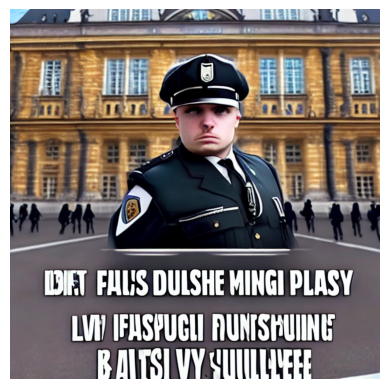

In [ ]:
model_id1 = "dreamlike-art/dreamlike-diffusion-1.0"
model_id2 = "stabilityai/stable-diffusion-xl-base-1.0"

pipe = StableDiffusionPipeline.from_pretrained(model_id1, torch_dtype=torch.float16, use_safetensors=True)
pipe = pipe.to("cuda")
prompt = omar
image = pipe(prompt).images[0]
plt.imshow(image);
plt.axis('off');

<div class="markdown-google-sans">
  <h2>What is Colab?</h2>
</div>

Colab, or "Colaboratory", allows you to write and execute Python in your browser, with
- Zero configuration required
- Access to GPUs free of charge
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more, or just get started below!

<div class="markdown-google-sans">

## **Getting started**
</div>

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

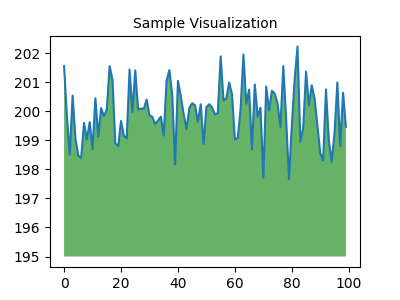

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb). Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning Crash Course

<div>

These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [NeMo Voice Swap](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb): Use Nvidia's NeMo conversational AI Toolkit to swap a voice in an audio fragment with a computer generated one.

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.
